In [83]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy.ndimage as ndi 
import rawpy as rp
import pylab as pl 
from IPython import display
import time
from collections import defaultdict
import os
from tqdm import tqdm




In [80]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 2] Das System kann die angegebene Datei nicht finden: 'c:\\Python311\\Scripts\\tqdm.exe' -> 'c:\\Python311\\Scripts\\tqdm.exe.deleteme'



In [4]:

directory = r'C:\Users\Nicla\OneDrive\Documents\University\Master\Practical Couse M\antibiotic_persistance\Lab_Course_Edelkoetter_Weisel'  # Replace with the actual directory path

# Get the distance between the images of the same sample
file_names = os.listdir(directory)
for i,f in enumerate(file_names):
    if i == len(file_names)-1:
        break
    if f[:15] != file_names[i+1][:15]:
        distance = i
        break



# Create a dictionary with the sample number as key and a list of the file names as values
samples_name_dict = defaultdict(list)
for i in range(int((len(file_names)-1)/(distance+1))):
    samples_name_dict[i+1]= file_names[((distance+1)*i):((distance+1)*(i+1))]
    if False: #set to True to convince yourself that the files are sorted correctly
        file_names_1 = file_names[((distance+1)*i):((distance+1)*(i+1))]
        print(file_names_1[0][:15], file_names_1[-1][:15], 'date:', file_names_1[0][16:-4],file_names_1[-1][16:-4])
        print(len(file_names_1))

# Create a dictionary with the sample number as key and a list of the time of the images as values        
samples_time_dict = defaultdict(list)
for key in samples_name_dict.keys():
    time_list = []
    for file_name in samples_name_dict[key]:
        date = time.strptime(file_name[16:-4], '%Y-%m-%d_%H-%M-%S')
        time_list.append(date)
    samples_time_dict[key] = time_list


In [ ]:
def calc_image(background, colonies):
    """calculates the difference between the background and the colonies"""

    blur_fc = 5
    blurred_colonies_intensity = ndi.gaussian_filter(colonies, sigma=blur_fc)
    blurred_background_intensity = ndi.gaussian_filter(background, sigma=blur_fc)
    return np.subtract(blurred_colonies_intensity, blurred_background_intensity, dtype=np.int16)

def diff_merged_colours(raw_image, raw_image_background):
    """calculates the difference between the raw images and the background images"""

    red = raw_image.raw_image_visible[::2,::2]
    green = raw_image.raw_image_visible[::2,1::2]
    blue = raw_image.raw_image_visible[1::2,1::2]
    green2 = raw_image.raw_image_visible[1::2,::2]

    background_red = raw_image_background.raw_image_visible[::2,::2]
    background_green = raw_image_background.raw_image_visible[::2,1::2]
    background_blue = raw_image_background.raw_image_visible[1::2,1::2]
    background_green_2 = raw_image_background.raw_image_visible[1::2,::2]

    diff_red = calc_image(background_red, red)
    diff_green = calc_image(background_green, green)
    diff_blue = calc_image(background_blue, blue)
    diff_green_2 = calc_image(background_green_2, green2)

    mean_diff = np.mean([diff_red, diff_green, diff_blue, diff_green_2], axis=0)

    return mean_diff[125:1525, 300:int(4850/2)]

def sort_out_maxima(maxima, diff):
    """sorts out maxima that are to close to each other or to the border"""

    r = 5
    updated_maxima_0 = maxima[0]
    updated_maxima_1 = maxima[1]
    index_to_delete = []

    #check wether colonies are to close to each other
    for i in range(len(maxima[0])-1):
        if np.sqrt((maxima[0][i] - maxima[0][i+1])**2 + (maxima[1][i] - maxima[1][i+1])**2) < 2* r:
            if diff[maxima[0][i], maxima[1][i]] > diff[maxima[0][i+1], maxima[1][i+1]]:
                index_to_delete.append(i+1)
            else:
                index_to_delete.append(i)
    
    #check wether colony is to close to the border
    for i in range(len(updated_maxima_0)):
        if updated_maxima_0[i] < r*2 or updated_maxima_0[i] > diff.shape[0] - r*2 or updated_maxima_1[i] < r*2 or updated_maxima_1[i] > diff.shape[1] - r*2:
            index_to_delete.append(i)
        
    updated_maxima_0 = np.delete(updated_maxima_0, index_to_delete)
    updated_maxima_1 = np.delete(updated_maxima_1, index_to_delete)
    


    return [updated_maxima_0, updated_maxima_1]


def radMask(index,radius,array):
    """returns a mask with a circle of radius around index"""
    a,b = index
    nx,ny = array.shape
    y,x = np.ogrid[-a:nx-a,-b:ny-b]
    mask = x*x + y*y <= radius*radius

    return mask

if False: #set to True to check algorithm
    import time
    #meanAll is going to store ~18000 points
    meanAll=[]
    for i in range(len(aprrox_maxima[0])):
        x = aprrox_maxima[0][i]
        y = aprrox_maxima[1][i]
        centerMask=(x,y)
        mask=radMask(centerMask,5,filtered_cropped_image)
        if False:
            pl.imshow(mask)
            display.clear_output(wait=True)
            display.display(pl.gcf())
            time.sleep(0.1)
        #un-mask center and values below 0
        mask[centerMask]=False
        mask[filtered_cropped_image<0]=False
        #get the mean
        meanAll.append(np.mean(filtered_cropped_image[mask]))

def get_int_within_r(maxima, image, r):
    """returns the mean intensity of the image within a radius r around the maxima"""

    meanAll=[]
    for i in range(len(maxima[0])):
        x = maxima[0][i]
        y = maxima[1][i]
        centerMask=(x,y)
        mask=radMask(centerMask,r,image)
        #un-mask center and values below 0
        mask[centerMask]=False
        mask[image<0]=False
        #get the mean
        meanAll.append(np.mean(image[mask]))
    return meanAll
    

               

In [6]:
for i,name in enumerate(samples_name_dict[2]):
    if name == 'd000661_350_002_2024-11-27_18-22-41.CR2':
        print(i) 
    if name == 'd000661_350_002_2024-11-28_09-22-47.CR2':
        print(i) 

5
35


In [84]:

samples_intensity_dict = defaultdict(list)

for key in tqdm(samples_name_dict.keys()):
    temp_raw_background = rp.imread(directory + '\\' + samples_name_dict[key][5])
    temp_raw_colonies_35 = rp.imread(directory + '\\' + samples_name_dict[key][35])
    temp_filtered_cropped_image_35 = diff_merged_colours(temp_raw_colonies_35, temp_raw_background)


    temp_blurred_diff = ndi.gaussian_filter(temp_filtered_cropped_image_35, sigma=5)
    temp_max_diff = ndi.maximum_filter(temp_blurred_diff, size=int(10/2))
    temp_aprrox_maxima = np.where(np.logical_and(temp_max_diff == temp_blurred_diff, np.greater(temp_max_diff, 800)))

    temp_sorted_maxima = sort_out_maxima(temp_aprrox_maxima, temp_filtered_cropped_image_35)

    samples_intensity_dict[key] = defaultdict(list)

    for curr_pic in tqdm(samples_name_dict[key]):
        if curr_pic == samples_name_dict[key][5]:
            for index, intensity in enumerate(temp_sorted_maxima[0]):
                samples_intensity_dict[key][index].append(0)
            continue
        if curr_pic == samples_name_dict[key][35]:
            temp_raw_colonies = temp_raw_colonies_35
            temp_filtered_cropped_image = temp_filtered_cropped_image_35
        else:
            temp_raw_colonies = rp.imread(directory + '\\' + curr_pic)
            temp_filtered_cropped_image = diff_merged_colours(temp_raw_colonies, temp_raw_background)

        temp_intensities = get_int_within_r(temp_sorted_maxima, temp_filtered_cropped_image, 5)
        for index, intensity in enumerate(temp_intensities):
            samples_intensity_dict[key][index].append(intensity)
    print('##############################################')
    print('done with sample:', key)

        
    # temp_intensities = get_int_within_r(temp_sorted_maxima, temp_filtered_cropped_image, 5)
    # intensity_dict = defaultdict(list)
    # for index, intensity in enumerate(intensities):
        # intensity_dict[index].append(intensity)
    

 12%|█▎        | 1/8 [04:29<31:23, 269.12s/it]

##############################################
done with sample: 1


 25%|██▌       | 2/8 [10:41<32:59, 329.85s/it]

##############################################
done with sample: 2


 38%|███▊      | 3/8 [15:32<26:01, 312.31s/it]

##############################################
done with sample: 3


 50%|█████     | 4/8 [21:52<22:36, 339.03s/it]

##############################################
done with sample: 4


 62%|██████▎   | 5/8 [26:44<16:05, 321.85s/it]

##############################################
done with sample: 5


 75%|███████▌  | 6/8 [31:47<10:31, 315.67s/it]

##############################################
done with sample: 6


 88%|████████▊ | 7/8 [36:41<05:08, 308.54s/it]

##############################################
done with sample: 7


100%|██████████| 8/8 [41:36<00:00, 312.02s/it]

##############################################
done with sample: 8


In [85]:
import pickle

with open('samples_intensity_dict_with_background_pic.pkl', 'wb') as f:
    pickle.dump(samples_intensity_dict, f)

In [ ]:
# load the dictionary samples_intensity_dict 
# samples_intensity_dict = pickle.load(open('samples_intensity_dict.pkl', 'rb'))

In [102]:
samples_time_dict[1][1]

time.struct_time(tm_year=2024, tm_mon=11, tm_mday=27, tm_hour=16, tm_min=21, tm_sec=48, tm_wday=2, tm_yday=332, tm_isdst=-1)

[1732767707.0, 1732767707.0, 1732767707.0, 1732767707.0, 1732771310.0, 1732767707.0, 1732767707.0, 1732769508.0, 1732769508.0, 1732771310.0, 1732769508.0, 1732767707.0, 1732769508.0]


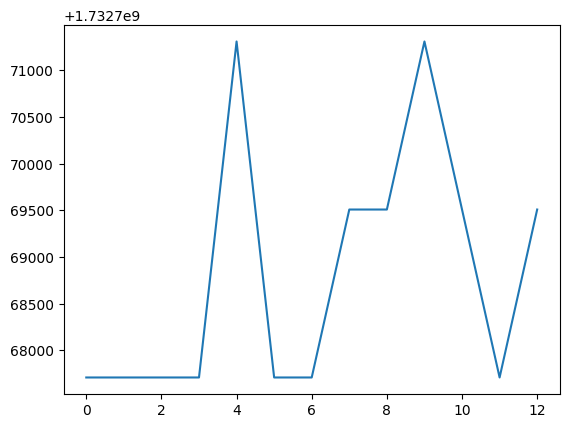

In [114]:
sampel = 1
wake_up_time_dict = defaultdict(list)

curr_wake_up_times = []
for key in samples_intensity_dict[sampel].keys():
    for i, curr_intensity in enumerate(samples_intensity_dict[sampel][key]):
        if curr_intensity > 1000:
            curr_wake_up_times.append(time.mktime(samples_time_dict[sampel][i]))
            break
wake_up_time_dict[sampel] = curr_wake_up_times

print(curr_wake_up_times)
plt.plot(curr_wake_up_times)
plt.show()

In [ ]:
"""Importing images"""

name_pct = 'd000661_350_002_2024-11-28_09-22-47.CR2'
raw_background = rp.imread('d000661_350_002_2024-11-27_18-22-41.CR2')
raw_colonies = rp.imread('d000661_350_002_2024-11-28_09-22-47.CR2')
# background_intensity = raw_background.raw_image_visible[250:3050, 600:4850]
# colonies_intensity = raw_colonies.raw_image_visible[250:3050, 600:4850]

raw_background.raw_colors_visible



array([[0, 1, 0, ..., 1, 0, 1],
       [3, 2, 3, ..., 2, 3, 2],
       [0, 1, 0, ..., 1, 0, 1],
       ...,
       [3, 2, 3, ..., 2, 3, 2],
       [0, 1, 0, ..., 1, 0, 1],
       [3, 2, 3, ..., 2, 3, 2]], dtype=uint8)

In [262]:
date = time.strptime(name_pct[16:-4], '%Y-%m-%d_%H-%M-%S')
print(date)


time.struct_time(tm_year=2024, tm_mon=11, tm_mday=28, tm_hour=9, tm_min=22, tm_sec=47, tm_wday=3, tm_yday=333, tm_isdst=-1)


In [195]:
raw_background.color_desc

b'RGBG'

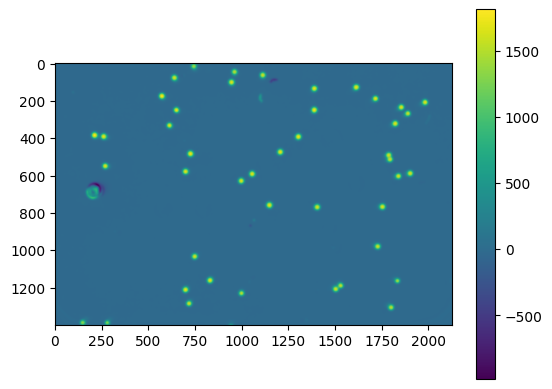

In [208]:
filtered_cropped_image = diff_merged_colours(raw_colonies, raw_background)
plt.imshow(filtered_cropped_image)
plt.colorbar()
plt.show()
plt.close()



44
[  17   47   64   79  102  129  136  176  190  209  236  251  251  269
  323  333  385  392  394  475  484  493  512  550  579  589  592  604
  629  759  768  770  980 1033 1161 1163 1189 1207 1211 1230 1284 1305
 1387 1387]


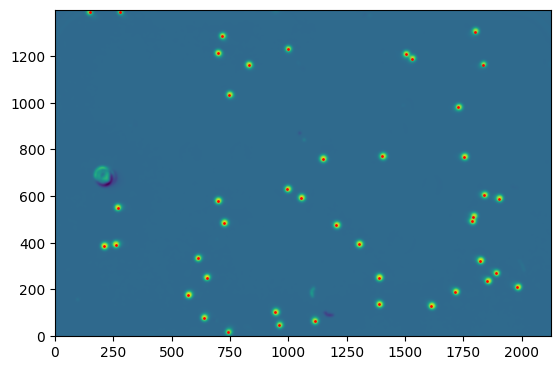

In [ ]:

blurred_diff = ndi.gaussian_filter(filtered_cropped_image, sigma=5)
max_diff = ndi.maximum_filter(blurred_diff, size=int(10/2))

aprrox_maxima = np.where(np.logical_and(max_diff == blurred_diff, np.greater(max_diff, 800)))
# aprrox_maxima = np.where(np.logical_and(max_diff == blurred_diff, np.greater(max_diff, 1000)))
# aprrox_maxima = np.where(max_diff == blurred_diff)

# check_max = max_diff.copy()
# check_max[aprrox_maxima] = 0
# plt.imshow(check_max)    
# plt.show()
print(len(aprrox_maxima[0]))
# plt.imshow(diff)
if True:
    plt.imshow(filtered_cropped_image)
    plt.scatter(aprrox_maxima[1], aprrox_maxima[0], c='r', s=1)
    plt.gca().invert_yaxis()

print(aprrox_maxima[0])





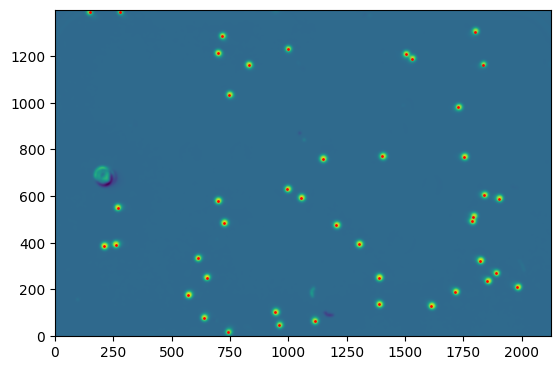

In [239]:
sorted_maxima = sort_out_maxima(aprrox_maxima, filtered_cropped_image)

plt.scatter(sorted_maxima[1], sorted_maxima[0], c='r', s=1)
plt.imshow(filtered_cropped_image)
plt.gca().invert_yaxis()
plt.show()
plt.close()


In [236]:
intensities = get_int_within_r(sorted_maxima, filtered_cropped_image, 5)

In [284]:

intensity_dict = defaultdict(list)
for index, intensity in enumerate(intensities):
    intensity_dict[index].append(intensity)


In [279]:
# for key in intensity_dict.keys():
    # intensity_dict[key].append(intensities[key])



In [313]:
x = np.arange(100)

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81
 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
